## Connet to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set all directories

The path are set according to the folders under the Google Drive. Hence, DO NOT change the path only if the path is changed accrodingly.  

In [ ]:
# Trained Model(parameters) path
MODEL_DIR = "/content/drive/MyDrive/data/model/"

# Folder path for Images to predict
PREDICT_IMAGE_DIR = "/content/drive/MyDrive/data/predict/predict_image/"

# Folder path for saving predict label
PREDICT_LABEL_DIR = "/content/drive/MyDrive/data/predict/predict_label/"

### Import Libraries and Modules

In [ ]:
# install imagecodecs for decode tif images
!pip install imagecodecs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 20.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import imagecodecs
import matplotlib.pyplot as plt
from pylab import *
#import json
#import cv2
import h5py
import imageio.v2 as imageio
from IPython.display import Image

import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Input,
    Activation,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    MaxPooling2D,
    UpSampling2D,
    concatenate
)
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#from tensorflow.compat.v1.logging import INFO, set_verbosity

#set_verbosity(INFO)

K.set_image_data_format("channels_first")



### Check runtime type (Important)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')
if len(tf.config.list_physical_devices('GPU')) == 0 :
  print("No GPU enable, check the runtime type!!!")

Num GPUs Available:  1
Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Encoder(DownSampling) Block

In [ ]:
def conv_block(inputs = None, n_filters = 32, dropout_prob = 0, max_pooling = True):


  """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
  """

  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation = 'relu',
                padding = 'same',
                kernel_initializer = 'he_normal')(inputs)

  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation = 'relu',
                padding = 'same',
                kernel_initializer = 'he_normal')(conv)

  # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
  if dropout_prob > 0:
    conv = Dropout(dropout_prob)(conv)

  # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
  if max_pooling:
    next_layer = MaxPooling2D(2, strides = 2)(conv)

  else:
    next_layer = conv

  skip_connection = conv

  return next_layer, skip_connection


### Decoder(UpSampling) Block

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
  """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
  """

    ### START CODE HERE
  up = Conv2DTranspose(filters = n_filters,
                       kernel_size = 3,
                       strides=2,
                       padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
  #merge = concatenate([up, contractive_input], axis=3)
  merge = concatenate([up, contractive_input], axis=1)
  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(merge)
  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(conv)

  return conv

### UNET Model

In [ ]:
def unet_model(input_size=(256, 256, 1), n_filters=32, n_classes=1):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block.
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False)

    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer.
    # At each step, use half the number of filters of the previous block
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    #conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    conv10 = Conv2D(filters = 1, kernel_size = 1, data_format = 'channels_first',activation='sigmoid')(conv9)
    ### END CODE HERE

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
unet= unet_model(input_size=(1,256, 256), n_filters=32, n_classes=1)
unet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['BinaryIoU'])
#unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 256, 256)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 256, 256)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 256, 256)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 128, 128)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

## [Edit] Choose the Model to load under model folder

In [ ]:
# Choose the model under the folder
model_name = "Model_weights_-20.hdf5"

### Load the trained Model/Weights

In [ ]:
# Load the Model

from tensorflow.keras.models import load_model
model = MODEL_DIR + model_name
print(f"Choosen Load Model is: {model}")
UNET_MODEL =unet.load_weights(model)

Choosen Load Model is: /content/drive/MyDrive/data/model/Model_weights_-20.hdf5


# [Edit] Choose the Image name to predict under PREDICT_IMAGE_DIR

In [ ]:
predict_filename = "X2248-60000X-29.tif"

### Load the predict file

In [ ]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [ ]:
image = np.array(imageio.imread(PREDICT_IMAGE_DIR + predict_filename))
img_scale=scaler.fit_transform(image.reshape(-1, 1)).reshape(image.shape)

if img_scale.shape == (1024,1024,3):
  img_scale = rgb2gray(img_scale)

print(img_scale.shape)

(1024, 1024)


### Predict and Reconstruct the Image

In [ ]:
predictions = np.zeros((1,1024,1024))
print(predictions.shape)

(1, 1024, 1024)


In [ ]:
#Define the dimension of the orignial image
orig_x = 1024
orig_y = 1024
#Define the dimension of sub-image
step_x = 256
step_y = 256
#Define the dimension of sub-image
output_x = 256
output_y = 256

seq=[]
predictions = np.zeros((1,1024,1024))


for x in range(0, orig_x-output_x+1, step_x):
    for y in range(0, orig_y-output_y+1, step_y):

            start_x = x
            start_y = y

            X = np.copy(img_scale[start_x: start_x + output_x,
                                  start_y: start_y + output_y])
            X = np.expand_dims(X, axis=0)
            X = np.expand_dims(X, axis=0)
            patch_prediction = unet.predict(X)
            predictions[0, start_x: start_x + output_x, start_y: start_y + output_y] = patch_prediction[0,0,:,:]





1/1 [==============================] - 0s 18ms/step


## Preview the origianl **image**

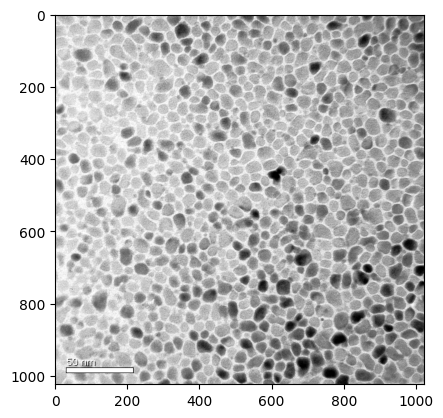

In [ ]:
plt.imshow(img_scale,  cmap = 'Greys_r')

## Preview the predict label

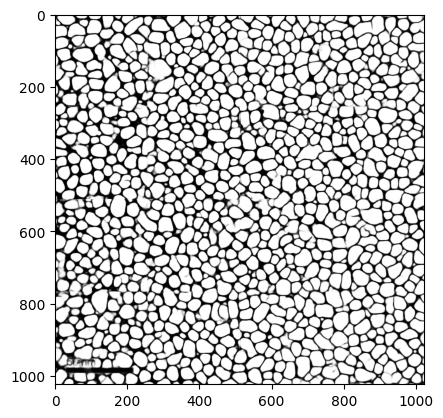

In [ ]:
plt.imshow(predictions[0,:,:], cmap='Greys_r')

## [Edit]Define the threshold value.
Threhold denotes the prediction probability, so shall be a value between 0 and 1.

In [ ]:
thres=0.8

## Preview the predict label according to the set threhold value.

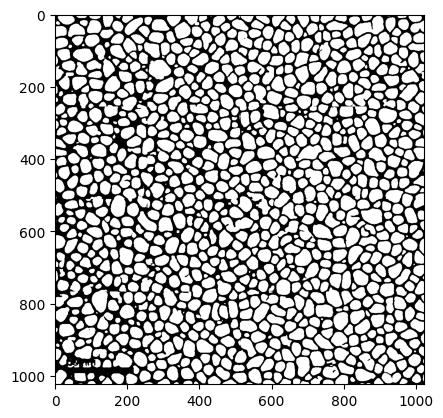

In [ ]:
pred_msk = predictions[0,:,:]
msk = np.zeros(pred_msk.shape)
msk[pred_msk >= thres] = 1
msk[pred_msk < thres] = 0
plt.imshow(msk, cmap = 'Greys_r')

## Save the label to PREDICT_LABEL_DIR

In [ ]:
file_= os.path.join(PREDICT_LABEL_DIR, f'{predict_filename}_{model_name}_threshold={thres}.png')
plt.imsave(file_, msk, cmap='gray')
print(f"Prediction Label saved to {PREDICT_LABEL_DIR}")